# Import packages

In [26]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# STATSMODELS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import zscore

# SKLEARN
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from mlxtend.evaluate import bias_variance_decomp

import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.4f}'.format # show only two digits
pd.set_option('display.max_columns', 100) # show up to 100 columns
np.random.seed(2023)

# CASE STUDY 5 - CAR SALES

## Part 1

## Car sales dataset (cleaned)

In [27]:
# Load cleaned dataset
cars_sales = pd.read_csv("case_5_car_sales_cleaned.csv")
cars_sales.head()

,manufact,model,sales,resale,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,type_labels,log_sales
0,Acura,Integra,16.9190,16.3600,0,21.5000,1.8000,140.0000,101.2000,67.3000,172.4000,2.6390,13.2000,28.0000,Automobile,2.8284
1,Acura,TL,39.3840,19.8750,0,28.4000,3.2000,225.0000,108.1000,70.3000,192.9000,3.5170,17.2000,25.0000,Automobile,3.6734
2,Acura,RL,8.5880,29.7250,0,42.0000,3.5000,210.0000,114.6000,71.4000,196.6000,3.8500,18.0000,22.0000,Automobile,2.1504
3,Audi,A4,20.3970,22.2550,0,23.9900,1.8000,150.0000,102.6000,68.2000,178.0000,2.9980,16.4000,27.0000,Automobile,3.0154
4,Audi,A6,18.7800,23.5550,0,33.9500,2.8000,200.0000,108.7000,76.1000,192.0000,3.5610,18.5000,22.0000,Automobile,2.9328


## Scaling the variables

In [88]:
# select the independent variables
independent_vars = ['type', 'price', 'engine_s', 'horsepow', 'wheelbas', 'width', 'length', 'curb_wgt', 'fuel_cap', 'mpg']

# create a new DataFrame with only the independent variables
X = cars_sales[independent_vars]

# scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y = cars_sales["log_sales"]

# create a new DataFrame with the scaled independent variables
X_scaled_df = pd.DataFrame(X_scaled, columns=independent_vars)

# scale the dependent variable
y_scaled = scaler.fit_transform(cars_sales["log_sales"].values.reshape(-1, 1))

# convert the scaled y back to a 1D array
y_scaled = y_scaled.flatten()

## Linear regression

### Scaled variables

In [29]:
# Start with OLS baseline
X_scaled_df = sm.add_constant(X_scaled_df)

model = sm.OLS(y_scaled, X_scaled_df)
linear_results = model.fit()
print(linear_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     13.31
Date:                Tue, 14 May 2024   Prob (F-statistic):           3.14e-16
Time:                        13:19:55   Log-Likelihood:                -165.17
No. Observations:                 152   AIC:                             352.3
Df Residuals:                     141   BIC:                             385.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.897e-16      0.060    4.8e-15      1.0

### Scaled coefficients

In [30]:
# Compute standard deviations
s_X = np.sqrt(np.var(X, axis=0))
s_y = np.sqrt(np.var(y))

X = sm.add_constant(X)

model_unscaled = sm.OLS(y, X)
linear_results = model_unscaled.fit()

# Get the "normal" coefficients
coefficients_unscaled = linear_results.params[1:]  # Exclude the constant term

coefficients_standardized = coefficients_unscaled * (s_X / s_y)
coefficients_compare = pd.DataFrame()
coefficients_compare["Unscaled"] = coefficients_unscaled
coefficients_compare["Standardized"] = coefficients_standardized

# Display the coefficients
display(coefficients_compare)

,Unscaled,Standardized
type,0.8830,0.2926
price,-0.0464,-0.5018
engine_s,0.3563,0.2805
horsepow,-0.0022,-0.0917
wheelbas,0.0416,0.2410
width,-0.0281,-0.0730
length,0.0146,0.1476
curb_wgt,0.1565,0.0747
fuel_cap,-0.0567,-0.1674
mpg,0.0812,0.2623


## Correlations

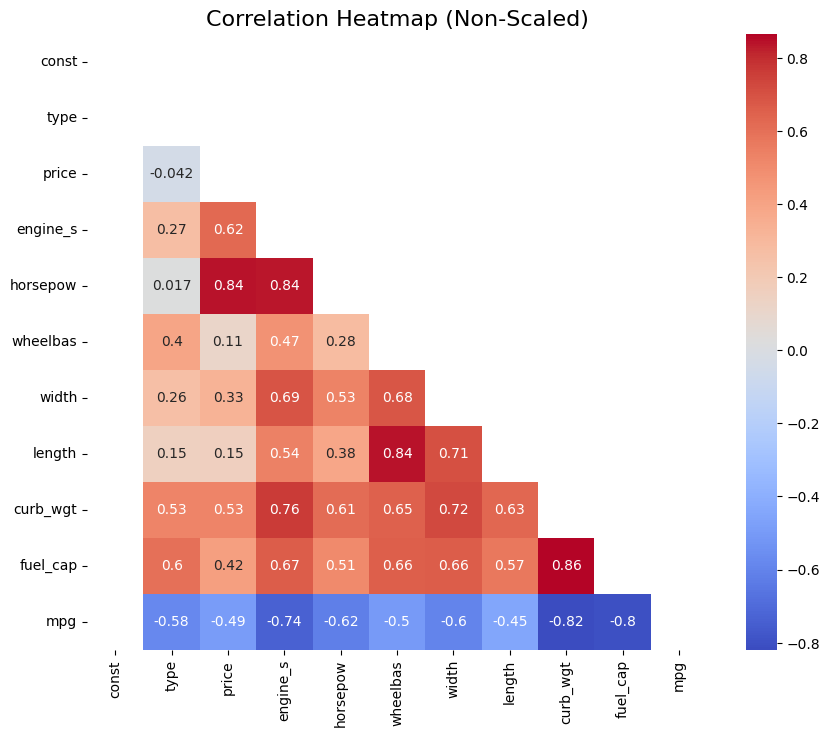

In [31]:
# plot correlation heatmap for non-scaled independent variables
plt.figure(figsize=(10, 8))
corr = X.corr().where(np.tril(np.ones(X.corr().shape), k=-1).astype(np.bool_))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Non-Scaled)', fontsize=16)
plt.show()

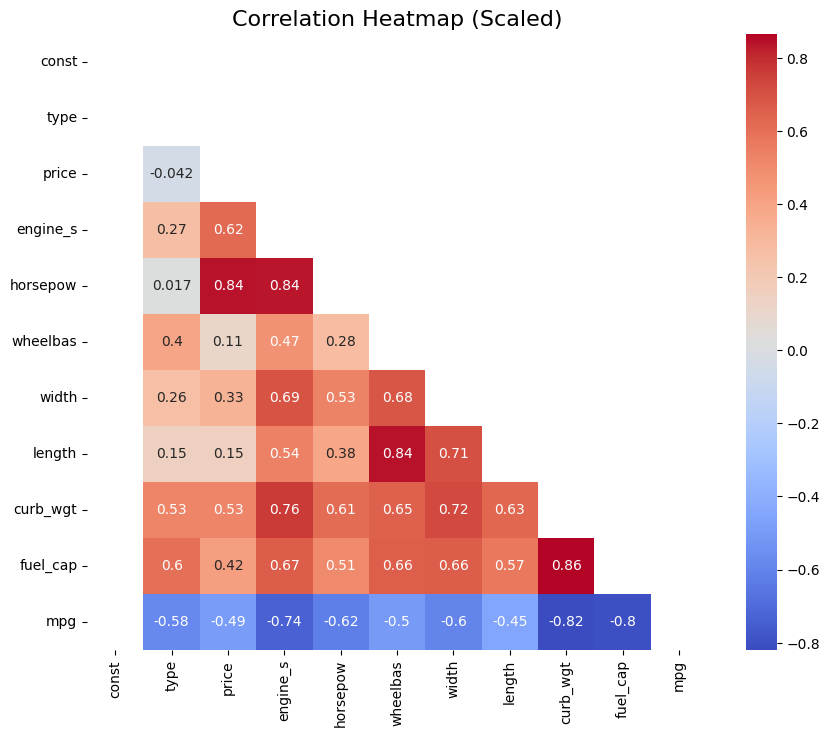

In [32]:
# plot correlation heatmap for scaled independent variables
plt.figure(figsize=(10, 8))
corr_scaled = X_scaled_df.corr().where(np.tril(np.ones(X_scaled_df.corr().shape), k=-1).astype(np.bool_))
sns.heatmap(corr_scaled, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Scaled)', fontsize=16)
plt.show()

## VIF

In [33]:
# Compute the VIF and tolerance for each independent variable
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Tolerance"] = [1 / vif["VIF"][i] for i in range(X.shape[1])]
vif.index = X.columns

# Display the VIF and tolerance DataFrame
display(vif)

,VIF,Tolerance
const,1165.9747,0.0009
type,3.2928,0.3037
price,5.3375,0.1874
engine_s,6.1592,0.1624
horsepow,8.8959,0.1124
wheelbas,4.9966,0.2001
width,3.1929,0.3132
length,5.6053,0.1784
curb_wgt,7.6441,0.1308
fuel_cap,5.3034,0.1886


## Ridge

In [106]:
# create a Ridge regression model
alpha = 0.1
ridge_results = model.fit_regularized(L1_wt=0, alpha=alpha, start_params=linear_results.params) # L1wt=0 for Ridge and L1wt=1 for Lasso
ridge_final = sm.regression.linear_model.OLSResults(model, 
                                              ridge_results.params, 
                                              model.normalized_cov_params)
# get the model summary
print(ridge_final.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     12.83
Date:                Tue, 14 May 2024   Prob (F-statistic):           1.01e-15
Time:                        14:54:29   Log-Likelihood:                -166.51
No. Observations:                 152   AIC:                             355.0
Df Residuals:                     141   BIC:                             388.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.824e-16      0.061   4.63e-15      1.0

### Mulitple penalties

In [119]:
results = []
for n in np.arange(0, 1.0, 0.05).tolist():
    ridge_results = model.fit_regularized(L1_wt=0, alpha=n, start_params=linear_results.params)

    ridge_results_fit = sm.regression.linear_model.OLSResults(model, 
                                                           ridge_results.params, 
                                                           model.normalized_cov_params)
    results.append(np.append(ridge_results.params, ridge_results_fit.mse_resid))

alpha_values_df = pd.DataFrame(results, columns=["const"] + independent_vars + ['mse_resid'])
alpha_values_df.index=np.arange(0, 1.0, 0.05).tolist()
alpha_values_df.index.name = 'alpha'

In [121]:
alpha_values_df

,const,type,price,engine_s,horsepow,wheelbas,width,length,curb_wgt,fuel_cap,mpg,mse_resid
alpha,,,,,,,,,,,,
0.0000,0.0000,0.2926,-0.5018,0.2805,-0.0917,0.2410,-0.0730,0.1476,0.0747,-0.1674,0.2623,0.5546
0.0500,0.0000,0.2684,-0.4477,0.2135,-0.1159,0.2181,-0.0420,0.1599,0.0314,-0.1332,0.2050,0.5581
0.1000,0.0000,0.2469,-0.4138,0.1672,-0.1268,0.2052,-0.0240,0.1595,0.0139,-0.1100,0.1702,0.5645
0.1500,0.0000,0.2293,-0.3883,0.1340,-0.1329,0.1958,-0.0124,0.1561,0.0053,-0.0930,0.1466,0.5717
0.2000,0.0000,0.2148,-0.3676,0.1090,-0.1365,0.1880,-0.0045,0.1517,0.0006,-0.0800,0.1295,0.5789
0.2500,0.0000,0.2027,-0.3501,0.0897,-0.1385,0.1814,0.0012,0.1472,-0.0022,-0.0697,0.1165,0.5860
0.3000,0.0000,0.1923,-0.3350,0.0744,-0.1394,0.1754,0.0054,0.1428,-0.0039,-0.0613,0.1063,0.5929
0.3500,0.0000,0.1833,-0.3217,0.0620,-0.1395,0.1700,0.0085,0.1385,-0.0049,-0.0545,0.0980,0.5997
0.4000,0.0000,0.1755,-0.3098,0.0519,-0.1391,0.1651,0.0109,0.1345,-0.0056,-0.0487,0.0911,0.6062


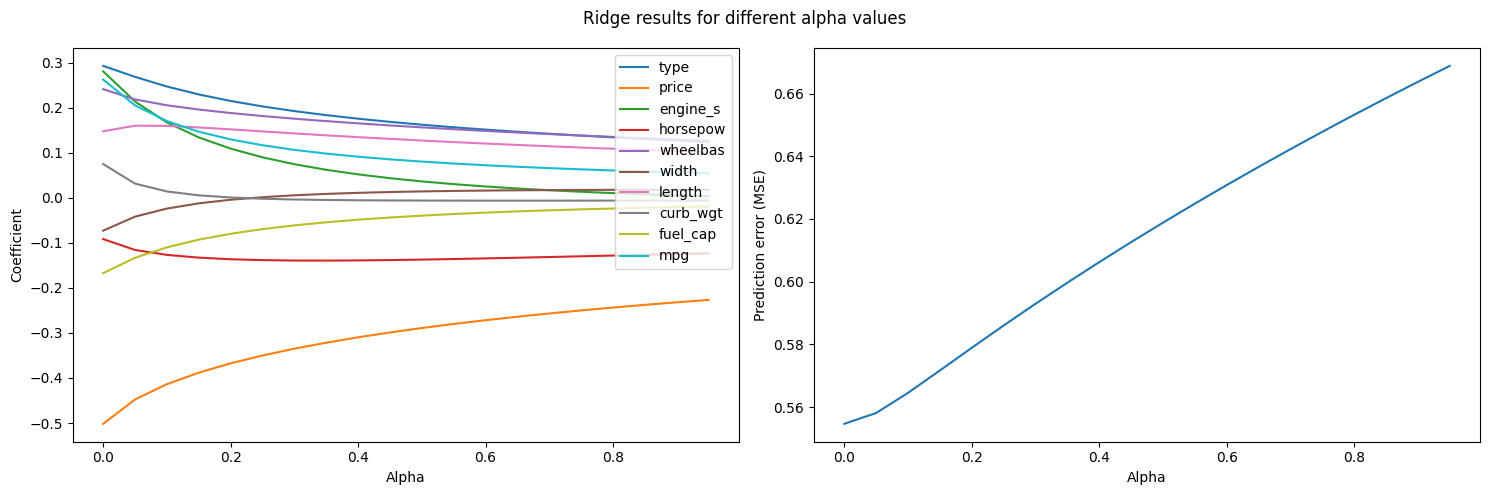

In [122]:
# plot the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# loop over the independent variables and plot each one as a separate line
for var in independent_vars:
    axs[0].plot(alpha_values_df.index, alpha_values_df[var], label=var)

axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Coefficient')
# axs[0].set_title('Ridge regression coefficients by alpha')
axs[0].legend(loc="upper right", frameon=True)

# loop over the independent variables and plot each one as a separate line
axs[1].plot(alpha_values_df.index, alpha_values_df["mse_resid"])
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Prediction error (MSE)')

fig.suptitle("Ridge results for different alpha values")
plt.tight_layout()
plt.show()

## Part 2

## Ridge & LASSO & cross-validation

### Train and test split

In [48]:
# Separate data between train and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.3, random_state=2023)

### Without cross-validation

In [124]:
# Create lasso and ridge objects
linear = LinearRegression()
lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.1)

# Fit models and print the best parameters, R-squared scores, MSE, and coefficients
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
linear.fit(X_train, y_train)

print("Ridge R2 score:", ridge.score(X_test, y_test))
print("LASSO R2 score:", lasso.score(X_test, y_test))
print("Linear R2 score:", linear.score(X_test, y_test))
print("--------------------------------------------------")
print("Ridge MSE:", mean_squared_error(y_test, ridge.predict(X_test)))
print("LASSO MSE:", mean_squared_error(y_test, lasso.predict(X_test)))
print("Linear MSE:", mean_squared_error(y_test, linear.predict(X_test)))


Ridge R2 score: 0.5939314871023442
LASSO R2 score: 0.5821751512603952
Linear R2 score: 0.5933963270172958
--------------------------------------------------
Ridge MSE: 0.6202616154401054
LASSO MSE: 0.6382191857253482
Linear MSE: 0.6210790618766747


### WITH cross-validation

In [174]:
# Reset the models
linear = LinearRegression()
lasso = Lasso()
ridge = Ridge()

# Create dictionary of hyperparameters (alpha)
alphasRidge = np.arange(0, 100, 1)
alphasLasso = np.arange(0, 1, 0.01)
parameters = {'alpha': np.concatenate((alphasLasso, alphasRidge))}
parameters_lasso = {'alpha': alphasLasso}
parameters_ridge = {'alpha': alphasRidge}
# Apply cross-validation
gridlasso = GridSearchCV(lasso, parameters_lasso, scoring ='r2', cv=10)
gridridge = GridSearchCV(ridge, parameters_ridge, scoring ='r2', cv=10)

# Fit models and print the best parameters, R-squared scores, MSE, and coefficients
gridlasso.fit(X_train, y_train)
gridridge.fit(X_train, y_train)
linear.fit(X_train, y_train)

print("Ridge best parameters:", gridridge.best_params_)
print("LASSO best parameters:", gridlasso.best_params_)
print("--------------------------------------------------")
print("Ridge R2 score:", gridridge.score(X_test, y_test))
print("LASSO R2 score:", gridlasso.score(X_test, y_test))
print("Linear R2 score:", linear.score(X_test, y_test))
print("--------------------------------------------------")
print("Ridge MSE:", mean_squared_error(y_test, gridridge.predict(X_test)))
print("LASSO MSE:", mean_squared_error(y_test, gridlasso.predict(X_test)))
print("Linear MSE:", mean_squared_error(y_test, linear.predict(X_test)))

Ridge best parameters: {'alpha': 21}
LASSO best parameters: {'alpha': 0.09}
--------------------------------------------------
Ridge R2 score: 0.5982092350053763
LASSO R2 score: 0.5850445294346889
Linear R2 score: 0.5933963270172958
--------------------------------------------------
Ridge MSE: 0.6137274401950307
LASSO MSE: 0.633836267362642
Linear MSE: 0.6210790618766747


## Plot prediction errors

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


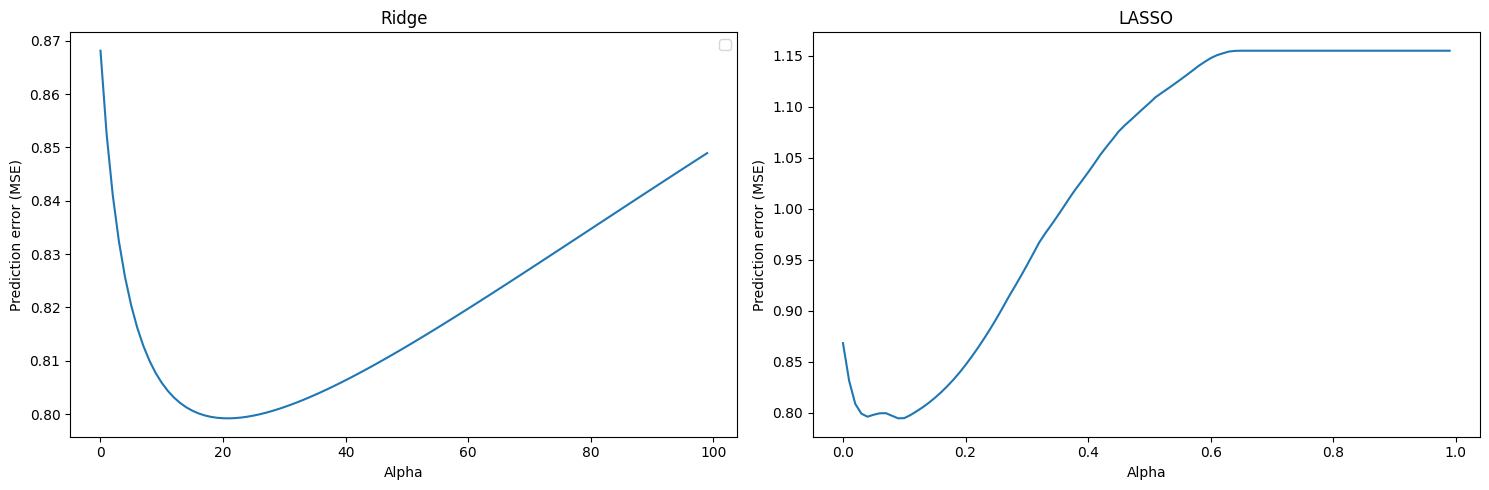

In [175]:
# plot the results

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df = pd.DataFrame(gridridge.cv_results_)
axs[0].plot(df["param_alpha"], 1-df["mean_test_score"])
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Prediction error (MSE)')
axs[0].set_title('Ridge')
axs[0].legend(loc="upper right", frameon=True)

df = pd.DataFrame(gridlasso.cv_results_)
axs[1].plot(df["param_alpha"], 1-df["mean_test_score"])
axs[1].set_xlabel('Alpha')
axs[1].set_title('LASSO')
axs[1].set_ylabel('Prediction error (MSE)')

plt.tight_layout()
plt.show()


#### Plot coefficients

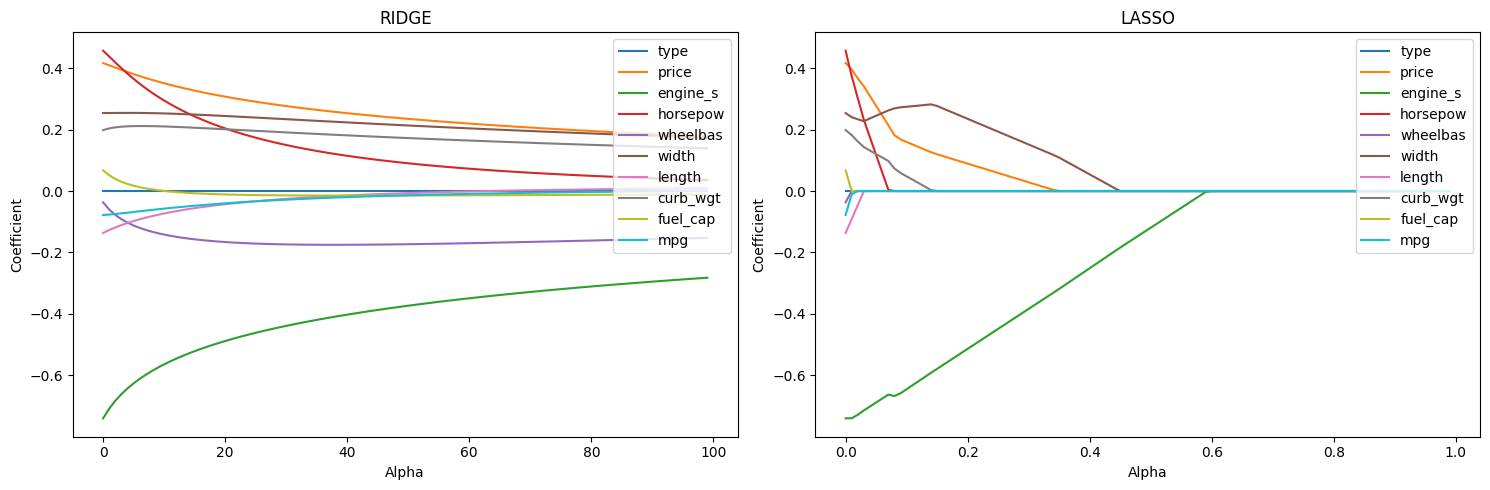

In [176]:
coefsRidge = []
coefsLasso = []

for i in range(len(alphasLasso)):
    lasso = Lasso(alpha=alphasLasso[i])
    lasso.fit(X_train, y_train)
    coefsLasso.append(lasso.coef_)
    
for i in range(len(alphasRidge)):
    ridge = Ridge(alpha=alphasRidge[i])
    ridge.fit(X_train, y_train)
    coefsRidge.append(ridge.coef_)

# Build Lasso and Ridge coefficient plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# loop over the independent variables and plot each one as a separate line
for i, var in enumerate(independent_vars):
    axs[0].plot(alphasRidge, np.array(coefsRidge)[:, i], label=var)

for i, var in enumerate(independent_vars):
    axs[1].plot(alphasLasso, np.array(coefsLasso)[:, i], label=var)

axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Coefficient')
axs[0].legend(loc="upper right", frameon=True)
axs[0].set_title('RIDGE')

axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Coefficient')
axs[1].legend(loc="upper right", frameon=True)
axs[1].set_title('LASSO')

plt.tight_layout()
plt.show()

#### Plot prediction errors (OOS instead of Crossval)

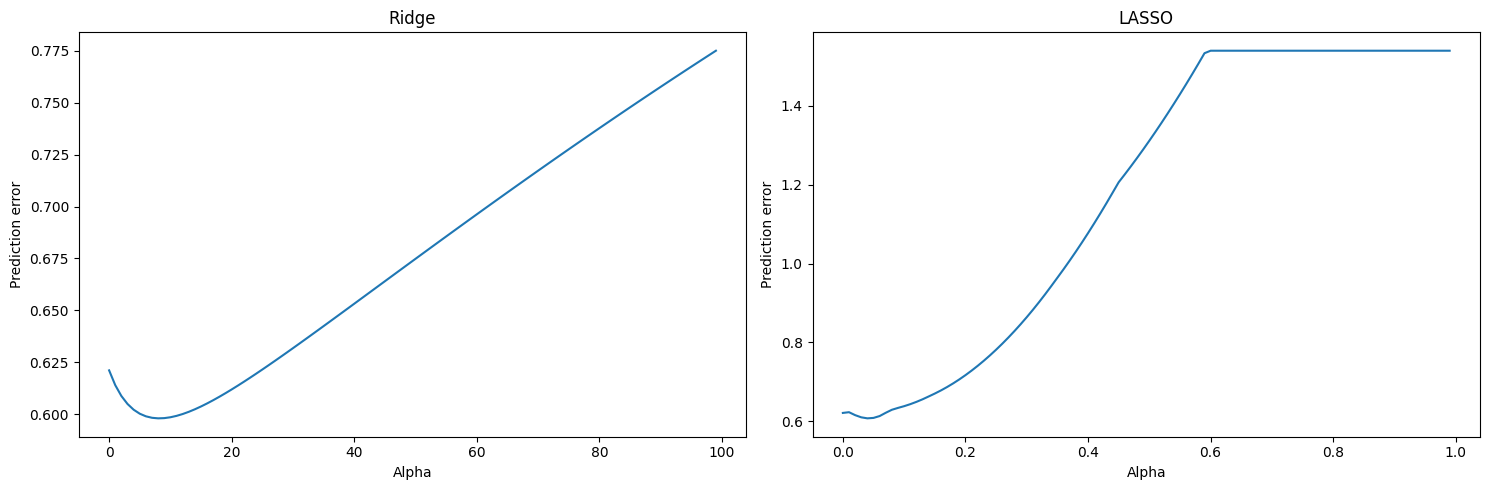

In [177]:
# Define function to calculate the apparent prediction error (OOS)
def prediction_error(model, X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)

# Get the SPE and EPE for Ridge and Lasso models
errorsRidge = []
errorsLasso = []

for alpha in alphasRidge:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    errorsRidge.append(prediction_error(ridge, X_test, y_test))

for alpha in alphasLasso:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    errorsLasso.append(prediction_error(lasso, X_test, y_test))

# Plot the results
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(alphasRidge, errorsRidge)
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('Prediction error')
axs[0].set_title('Ridge')

axs[1].plot(alphasLasso, errorsLasso)
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('Prediction error')
axs[1].set_title('LASSO')

plt.tight_layout()
plt.show()

In [179]:
# Find alpha value with minimum prediction error
min_error_ridge = min(errorsRidge)
min_alpha_ridge = alphasRidge[errorsRidge.index(min_error_ridge)]
print(f"Minimum prediction error for Ridge: {min_error_ridge:.2f}, alpha: {min_alpha_ridge:.2f}")

min_error_lasso = min(errorsLasso)
min_alpha_lasso = alphasLasso[errorsLasso.index(min_error_lasso)]
print(f"Minimum prediction error for LASSO: {min_error_lasso:.2f}, alpha: {min_alpha_lasso:.2f}")

Minimum prediction error for Ridge: 0.60, alpha: 8.00
Minimum prediction error for LASSO: 0.61, alpha: 0.04


#### [ADVANCED] EXTRA: Plot bias and variance decomposition

For alpha: 14
MSE Ridge: 0.659
Bias Ridge: 0.590
Variance Ridge: 0.069
-------------------------------
For alpha: 0.06
MSE LASSO: 0.673
Bias LASSO: 0.596
Variance LASSO: 0.077


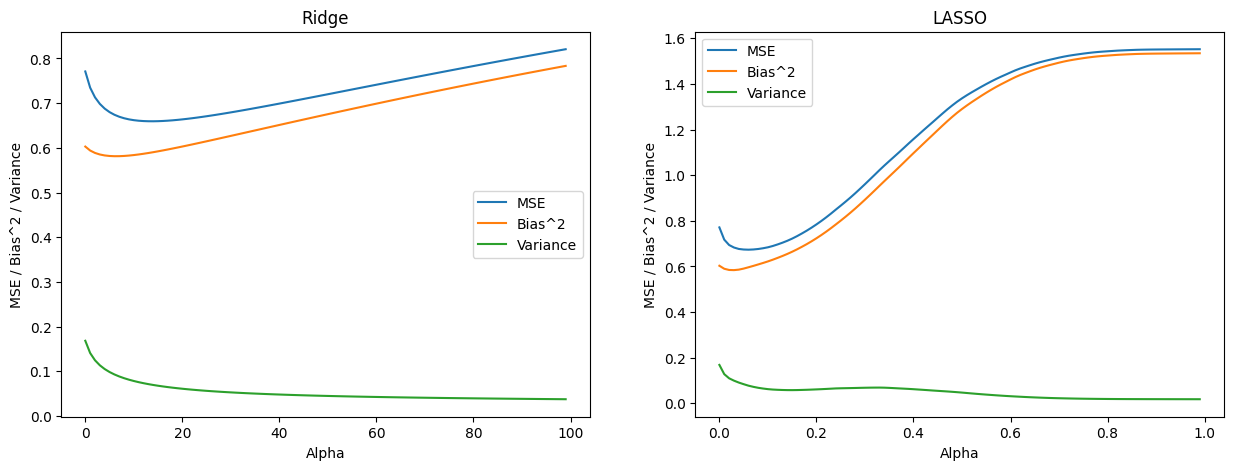

In [191]:
# Convert DataFrames to NumPy arrays
X_train_values = X_train.values
y_train_values = y_train.values
X_test_values = X_test.values
y_test_values = y_test.values

# Create subplots for Ridge and Lasso regularization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Define arrays to hold MSE, bias, and variance values
mse_ridge = []
bias_ridge = []
variance_ridge = []

mse_lasso = []
bias_lasso = []
variance_lasso = []

# Loop over the shrinkage values and fit Ridge and Lasso models
for i in range(len(alphasRidge)):
    ridge = Ridge(alpha=alphasRidge[i])
    ridge.fit(X_train_values, y_train_values)
    
    error_reg_ridge, bias_reg_ridge, var_reg_ridge = bias_variance_decomp(ridge, X_train_values, y_train_values, X_test_values, y_test_values, loss='mse',  num_rounds=100, random_seed=2023)
    
    mse_ridge.append(error_reg_ridge)
    bias_ridge.append(bias_reg_ridge)
    variance_ridge.append(var_reg_ridge)

for i in range(len(alphasLasso)):
    lasso = Lasso(alpha=alphasLasso[i])
    lasso.fit(X_train_values, y_train_values)
    
    error_reg_lasso, bias_reg_lasso, var_reg_lasso = bias_variance_decomp(lasso, X_train_values, y_train_values, X_test_values, y_test_values, loss='mse', num_rounds=100, random_seed=2023)
    
    mse_lasso.append(error_reg_lasso)
    bias_lasso.append(bias_reg_lasso)
    variance_lasso.append(var_reg_lasso)

# Plot MSE, bias, and variance for Ridge regularization
axs[0].plot(alphasRidge, mse_ridge, label='MSE')
axs[0].plot(alphasRidge, bias_ridge, label='Bias^2')
axs[0].plot(alphasRidge, variance_ridge, label='Variance')
axs[0].legend(loc='best')
axs[0].set_xlabel('Alpha')
axs[0].set_ylabel('MSE / Bias^2 / Variance')
axs[0].set_title('Ridge')

# Plot MSE, bias, and variance for Lasso regularization
axs[1].plot(alphasLasso, mse_lasso, label='MSE')
axs[1].plot(alphasLasso, bias_lasso, label='Bias^2')
axs[1].plot(alphasLasso, variance_lasso, label='Variance')
axs[1].legend(loc='best')
axs[1].set_xlabel('Alpha')
axs[1].set_ylabel('MSE / Bias^2 / Variance')
axs[1].set_title('LASSO')
idxr = np.argmin(mse_ridge)
idxl = np.argmin(mse_lasso)
print(f"For alpha: {alphasRidge[idxr]}")
print('MSE Ridge: %.3f' % mse_ridge[idxr])
print('Bias Ridge: %.3f' % bias_ridge[idxr])
print('Variance Ridge: %.3f' % variance_ridge[idxr])
print("-------------------------------")
print(f"For alpha: {alphasLasso[idxl]}")
print('MSE LASSO: %.3f' % mse_lasso[idxl])
print('Bias LASSO: %.3f' % bias_lasso[idxl])
print('Variance LASSO: %.3f' % variance_lasso[idxl])